In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [3]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Fired Amazon worker files discrimination lawsuit over pandemic conditions
Nov-12-20 09:13PM  
Cisco Jumps on Forecast; CEO Sees Signs of Improvement
07:23PM  
Amazon Lawsuits: Luxury Counterfeiters Wielded Social to Peddle Fakes
05:33PM  
Alibabas Singles Day Sales Growth Keeps Pace
05:32PM  


In [4]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

 '05:21PM',
  'Dow Jones Futures: Stock Market Rotation Over? Moderna Breaks Out; Pinduoduo, Tencent, Tesla Rival Xpeng Earnings Due'],
 ['TSLA',
  'Nov-11-20',
  '04:25PM',
  'Tesla No. 1 in Survey of Most Attractive Companies for Engineering Students'],
 ['TSLA',
  'Nov-11-20',
  '04:05PM',
  "Electric Car Sales More Than Double In World's Biggest EV Market, But Tesla Lags"],
 ['TSLA',
  'Nov-11-20',
  '03:15PM',
  'Will Tesla Or Nio Stock Grow More By 2025?'],
 ['TSLA',
  'Nov-11-20',
  '12:03PM',
  'Mercedes-Benz Berlin plant head to join Tesla, union says'],
 ['TSLA',
  'Nov-11-20',
  '11:39AM',
  'Dow Jones Rallies 150 Points, As Tech Stocks Snap Back; Apple, Tesla Rebound, But Datadog Plunges On Earnings'],
 ['TSLA',
  'Nov-11-20',
  '10:35AM',
  "BMW's New Electric iX SUV Will Challenge Tesla, But Not Until 2022"],
 ['TSLA',
  'Nov-11-20',
  '08:58AM',
  'BMW unveils electric SUV to challenge Tesla, plans U.S. launch in early 2022'],
 ['TSLA',
  'Nov-11-20',
  '08:54AM',
  'BMW

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import nltk
#nltk.download('vader_lexicon')

# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2020-11-12,09:13PM,Fired Amazon worker files discrimination lawsu...,0.417,0.455,0.129,-0.5859
1,AMZN,2020-11-12,07:23PM,Cisco Jumps on Forecast; CEO Sees Signs of Imp...,0.000,0.727,0.273,0.4588
2,AMZN,2020-11-12,05:33PM,Amazon Lawsuits: Luxury Counterfeiters Wielded...,0.364,0.496,0.140,-0.4019
3,AMZN,2020-11-12,05:32PM,Alibabas Singles Day Sales Growth Keeps Pace,0.000,0.698,0.302,0.3818
4,AMZN,2020-11-12,05:30PM,Nike Stock: Is It A Buy As Digital Sales Soar ...,0.272,0.728,0.000,-0.6249


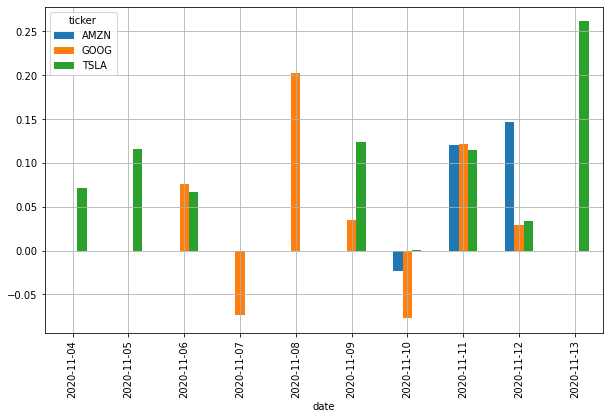

In [8]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()